In [11]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from category_encoders import TargetEncoder

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

from datetime import datetime

warnings.filterwarnings("ignore")

In [12]:
DATASET_SAMPLE = r"project_data_from_kaggle\sample_submission.csv"
DATASET_TEST = r"project_data_from_kaggle\test.csv"
DATASET_TRAIN = r"project_data_from_kaggle\train.csv"

In [13]:
orig_sample = pd.read_csv(DATASET_SAMPLE, sep=",")
orig_test = pd.read_csv(DATASET_TEST, sep=",")
orig_train = pd.read_csv(DATASET_TRAIN, sep=",")
df = orig_train
df_test = orig_test
df_sampl = orig_sample

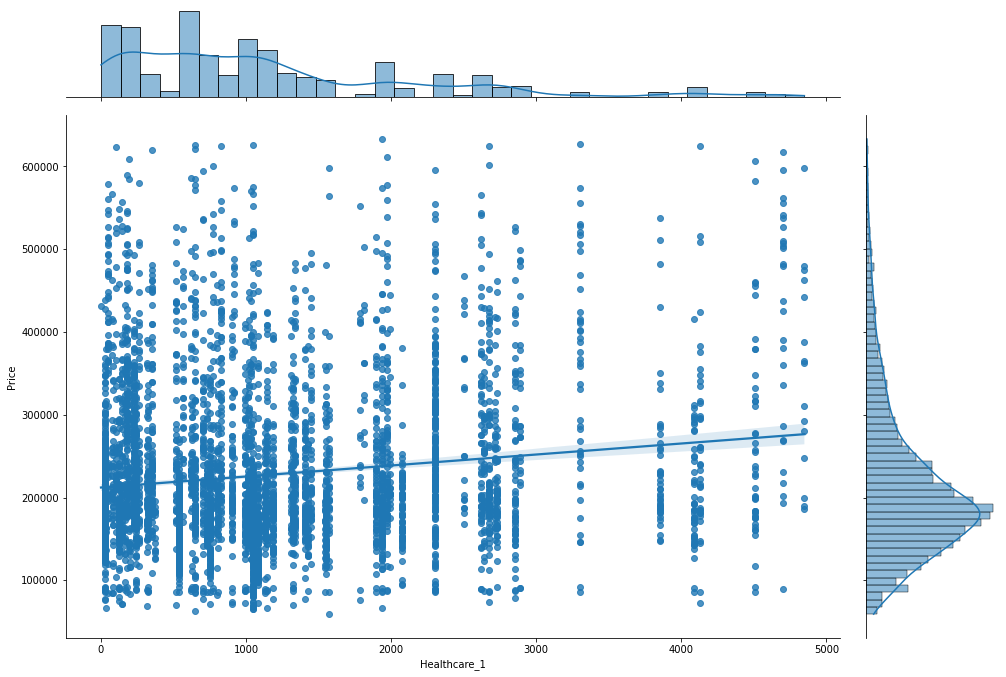

In [14]:
grid = sns.jointplot(df['Healthcare_1'], df['Price'], kind='reg')
grid.fig.set_figwidth(15)
grid.fig.set_figheight(10)

plt.show()

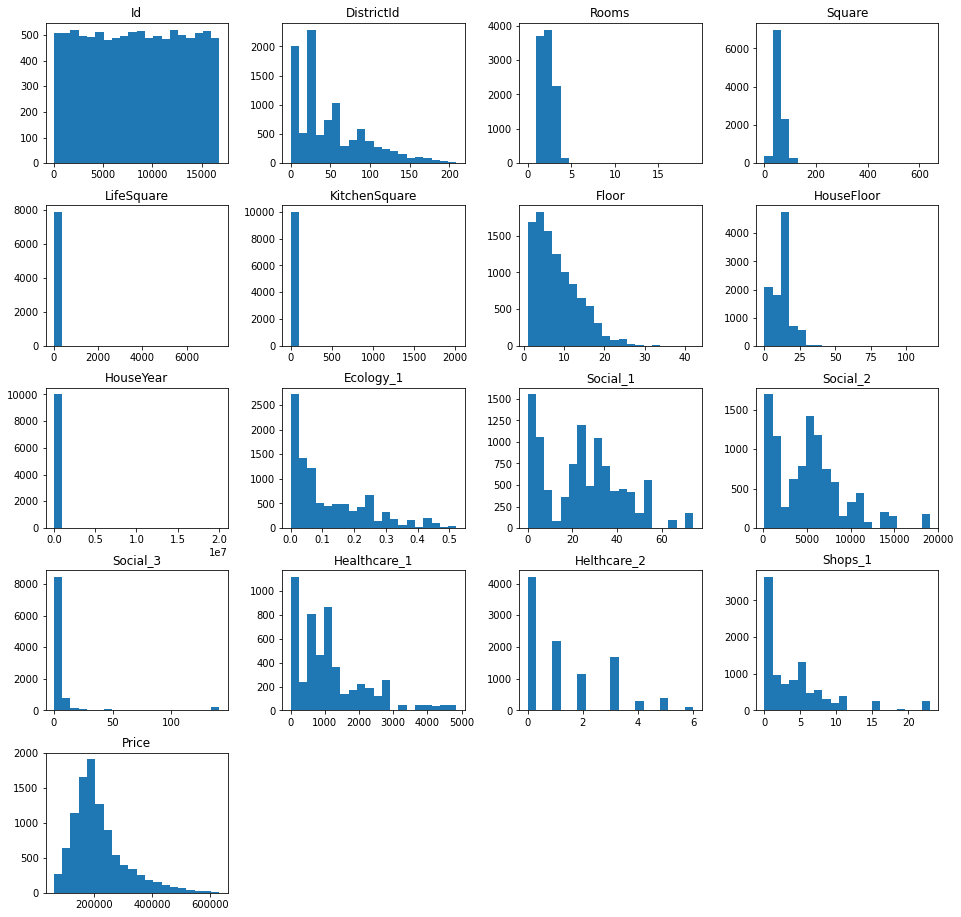

In [15]:
df.hist(figsize=(16,16), bins=20, grid=False);

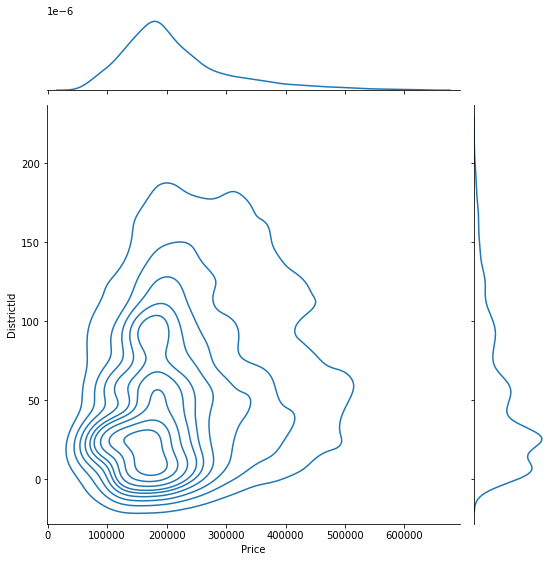

In [16]:
grid = sns.jointplot(df['Price'], df['DistrictId'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [17]:
class PipeLine:        
    
    def transform(self, df):
        
#         Переименование колонки
        df.rename(columns={"Helthcare_2":"Healthcare_2"}, inplace=True)
        
#         Объявление всех новых колонок для вычеслений
        df["LifeSquare_non"] = 0
        df["Healthcare_1_non"] = 0
        df["for_search_strange_square"] = 0
        df["change_S_a_LS"] = 0
        df["change_LS_a_S"] = 0
        df['Ecology_2_new'] = 0
        df["Shops_2_new"] = 0
        df["Ecology_3_new"] = 0
        df["strange_KitchenSquare"] = 0
        df["mediana_flor_in_house"] = 0
        df["Class_Floor"] = 0
        df["Class_HouseYear"] = 0
        df.loc[df.LifeSquare > df.Square, "for_search_strange_square"] = 1
        df.loc[df["LifeSquare"].isna(), "LifeSquare_non"] = 1
        df.loc[df["Healthcare_1"].isna(), "Healthcare_1_non"] = 1
        
        proc = df[df.LifeSquare_non == 0]
        
#         LifeSquare == Nan
        proc["procent_for_LS"] = (proc.Square - proc.LifeSquare - proc.KitchenSquare) / proc.Square
        median_free_square = proc["procent_for_LS"].median()
        df["proc_free_square"] = df.Square * (1 - median_free_square) - df.KitchenSquare
        df.loc[df["LifeSquare_non"] == 1, "LifeSquare"] = df["proc_free_square"]
        
#         Healthcare
        df["Healthcare_1_mode"] = 0.1
        hc_1_md = df.loc[df["Healthcare_1_non"] == 0]
        districtId_any_0 = hc_1_md["DistrictId"].unique()
        districtId_any_0.sort()
# #         Перебор районов для заполнения данный в здравоохранении_1
        for i in districtId_any_0:
            Healthcare_in_distr = df.loc[((df.DistrictId == i) & (df.Healthcare_1_non == 0))]
            df.loc[df.DistrictId == i, "Healthcare_1_mode"] = Healthcare_in_distr.Healthcare_1.mode()[0]
            
        hc1_mode_for_transform = df.loc[((df.Healthcare_1_mode != 0.1) & (df.Healthcare_1_non == 1))]
        df.loc[df.Healthcare_1_non == 1, "Healthcare_1"] = hc1_mode_for_transform.Healthcare_1_mode
        df.loc[df.Healthcare_1.isnull(), "Healthcare_1"] = df.Healthcare_1.median()
        
#         Корректировака выбросов
        df.loc[df.LifeSquare > 640, "LifeSquare"] = df.loc[df.LifeSquare > 640, "LifeSquare"]/100
        df.loc[df.LifeSquare < 0, "LifeSquare"] = df.loc[df.LifeSquare < 0, "LifeSquare"] * -1
        df.loc[df.KitchenSquare > 150, "KitchenSquare"] = df.loc[df.KitchenSquare > 150, "KitchenSquare"]/100
        
#         LifeSquare - замена странных значений
        change_LS_a_s = df[df.LifeSquare > df.Square]
        change_LS_a_s = df[df.for_search_strange_square == 1]
        df.loc[df.for_search_strange_square == 1, "change_LS_a_S"] = df.LifeSquare.loc[df.for_search_strange_square > 0]
        df.loc[df.for_search_strange_square == 1, "change_S_a_LS"] = df.Square.loc[df.for_search_strange_square > 0]
        df.loc[df.for_search_strange_square == 1, "LifeSquare"] = df.change_S_a_LS.loc[df.for_search_strange_square > 0]
        df.loc[df.for_search_strange_square == 1, "Square"] = df.change_LS_a_S.loc[df.for_search_strange_square > 0]
        
#         Ecology, Shops and again Ecology
        df.loc[df['Ecology_2'] == "A", 'Ecology_2_new'] = "Ecology_2_A"
        df.loc[df['Ecology_2'] == "B", 'Ecology_2_new'] = "Ecology_2_B"
        df.loc[df['Shops_2'] == "A", 'Shops_2_new'] = "Shops_2_A"
        df.loc[df['Shops_2'] == "B", 'Shops_2_new'] = "Shops_2_B"
        df.loc[df['Ecology_3'] == "A", 'Ecology_3_new'] = "Ecology_3_A"
        df.loc[df['Ecology_3'] == "B", 'Ecology_3_new'] = "Ecology_3_B"
        
        df = pd.concat([df, pd.get_dummies(df.Ecology_2_new)], axis=1)
        df = pd.concat([df, pd.get_dummies(df.Ecology_3_new)], axis=1)
        df = pd.concat([df, pd.get_dummies(df.Shops_2_new)], axis=1)
        
#         Housefloor
        df.loc[df.Floor < df.HouseFloor, "mediana_flor_in_house"] = df.HouseFloor - df.Floor
        procent_for_normal_floor = df[df.Floor < df.HouseFloor]
        median_proc_floor = procent_for_normal_floor.mediana_flor_in_house.median() 
        df.loc[df.Floor > df.HouseFloor, "HouseFloor"] = df.Floor + median_proc_floor
        
#         HouseYear
        df.loc[df.HouseYear > 2022, "HouseYear"] = 2022
    
#         Rooms
        for_null_rooms = df.loc[df.Rooms == 0]
        df.loc[df.Rooms == 0, "Rooms"] = for_null_rooms.Square // 30
        df.loc[df.Square < 30, "Rooms"] = 1
        
        df.drop("mediana_flor_in_house", axis=1, inplace=True)
        df.drop(["change_LS_a_S","for_search_strange_square", "change_S_a_LS", "Healthcare_1_non", ] ,axis=1, inplace=True)
        df.drop(["proc_free_square", 'LifeSquare_non', 'Healthcare_1_mode'], axis=1, inplace=True)
        df.drop(columns=["Ecology_2","Ecology_3","Shops_2"], inplace=True)
        df.drop(columns=["Ecology_2_new","Ecology_3_new","Shops_2_new", "Shops_2_B", "Ecology_2_B", "Ecology_3_B"], inplace=True)
        
#         to str
        df['Id'] = df['Id'].astype(str)
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        return df

In [18]:
class NewFestures:
        
    def Transform(self, df):
        
#         Kitchen
        df["strange_KitchenSquare"] = df.Square - df.LifeSquare - df.KitchenSquare
    
#         cls_floor
        df.loc[df.Floor <= 3 ,"Class_Floor"] = 1
        df.loc[df.Floor == df.HouseFloor, "Class_Floor"] = 2
        df.loc[df.Class_Floor == 0, "Class_Floor"] = 3
        
#         cls_house
        df.loc[df.HouseYear < 1940, "Class_HouseYear"] = 1
        df.loc[((df.HouseYear < 1960)&(df.HouseYear == 0)), "Class_HouseYear"] = 2
        df.loc[((df.HouseYear < 1980)&(df.HouseYear == 0)), "Class_HouseYear"] = 3
        df.loc[((df.HouseYear < 2000)&(df.HouseYear == 0)), "Class_HouseYear"] = 4
        df.loc[((df.HouseYear < 2023)&(df.HouseYear == 0)), "Class_HouseYear"] = 5
        
        return df

In [19]:
preprocess = PipeLine()
df = preprocess.transform(df)
df_test = preprocess.transform(df_test)


In [20]:
new_features = NewFestures()
new_features.Transform(df)
new_features.Transform(df_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Healthcare_2,Shops_1,strange_KitchenSquare,Class_Floor,Class_HouseYear,Ecology_2_A,Ecology_3_A,Shops_2_A
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,1036.0,1,1,12.753448,3,0,0,0,0
1,5925,62,1.0,42.568133,42.493907,10.0,7,17.0,2017,0.072158,...,1,2300.0,0,0,-9.925775,3,0,0,0,1
2,960,27,2.0,59.463678,36.535493,9.0,19,19.0,1977,0.211401,...,0,810.0,0,1,13.928185,2,0,0,0,0
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0.0,0,0,9.752204,2,0,0,0,0
4,746,74,1.0,53.837056,40.226795,1.0,8,17.0,1977,0.309479,...,4,990.0,0,6,12.610261,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,12.0,1962,0.069660,...,4,1547.0,1,2,7.837576,3,0,0,0,0
4996,16138,38,3.0,94.521465,93.698122,10.0,21,27.0,2018,0.060753,...,2,520.0,0,7,-9.176657,3,0,0,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,...,1,1015.0,2,5,9.653464,1,0,0,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,...,5,810.0,0,11,8.658898,3,0,0,0,0


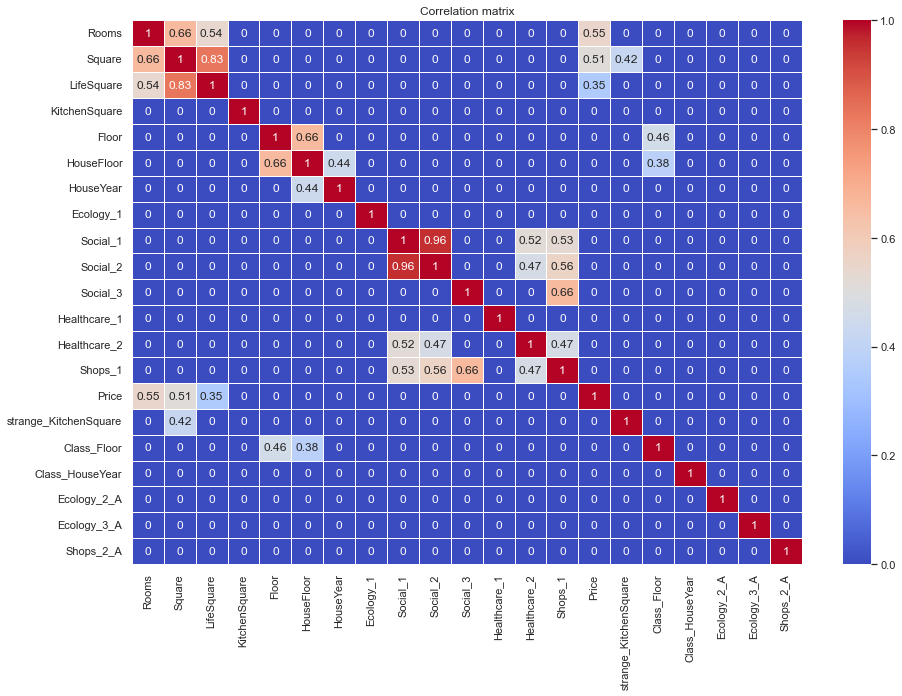

In [21]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [22]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Healthcare_2', 'Shops_1',
       'strange_KitchenSquare', 'Class_Floor', 'Ecology_2_A',
       'Ecology_3_A', 'Shops_2_A',]
target_name = 'Price'
df = df[feature_names + [target_name]]
df_test = df_test[feature_names]

In [23]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.33, random_state = 42)

In [24]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=5,
                                        random_state=42,
                                        n_estimators=750)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=5,
                          n_estimators=750, random_state=42)

In [25]:
predictions = final_model.predict(df_test)

In [26]:
df_sampl['Price'] = predictions

In [27]:
df_sampl.to_csv('gb_submit.csv', index=False)